### Friends Recommender In Social Network

#### Эмбеддинги и Кластеризация 

https://github.com/iamsinghrajat/Friends-Recommender-In-Social-Networkz


Tutorial Pytorch Geometric  
https://github.com/AntonioLonga/PytorchGeometricTutorial  
https://www.youtube.com/watch?v=m1G7oS9hmwE  


Dataset: https://snap.stanford.edu/data/ego-Facebook.html   
Датасет содержит 10 графов.   
Каждый граф имеет свои вершины, ребра, фичи.  

In [3]:
# !pip install torchnet networkx
%matplotlib inline

import json
import collections
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import ReLU, Linear, Dropout

from torch_geometric.data import Data
# from torch_geometric.transforms import AddTrainValTestMask as masking
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv, Sequential
from torch_geometric.nn.norm import BatchNorm

import os
from os.path import exists

import networkx as nx

## Формируем граф

In [4]:
DATASET_PATH = "datasets/SNAP_ego-Facebook/"
dataset_file = "facebook_combined.txt" 
FEATURES_PATH =  "datasets/SNAP_ego-Facebook/facebook/"

In [5]:
nets = [0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980]
graph_nets = {}
nodes_nets = {k:set([]) for k in nets}

In [6]:
def add_edge(g, node1, node2):
    if node1 in g:
        g[node1].add(node2)
    else:
        g[node1] = set([node2])
    
# Первичное заполенние ребер графа из файла facebook_combined.txt, далее будет еще дозаполнятся из доп данных, 
# там почему-то связи разнятся с тем что тут указано. Возможно это сделано в качестве деления трайн/тест 
def beginer_load_graph(filename=DATASET_PATH + dataset_file):
    graph = {}
    with open(filename, "r") as file:
        for row in file:
            row = row.strip().split()
            if len(row) < 2:
                continue
            node1_id, node2_id = list(map(int, row))
            add_edge(graph, node1_id, node2_id)
            add_edge(graph, node2_id, node1_id)
    return graph
begin_graph = beginer_load_graph()

In [7]:
# def load_features(nets):
#     nodes_features = {}
#     # загружаем фичи основных узлов по сетям
#     for net_num in nets:
#         ego_filename = FEATURES_PATH + f"{net_num}.egofeat"
#         with open(ego_filename, "r") as file:
#             node_feat = file.readline().strip().split()
#             nodes_features[net_num] = list(map(int, node_feat))
#         # загружаем все остальные фичи по узлам
#         nodes_features
#         feats_filename = FEATURES_PATH + f"{net_num}.feat"
#         with open(feats_filename, "r") as file:
#             for row in file:
#                 node_feat = row.strip().split()
#                 node_feat = list(map(int, node_feat))
#                 nodes_features[node_feat[0]] = node_feat[1:]
#     return nodes_features

    
# nodes_features = load_features(nets=nets)
# assert len(nodes_features) == len(begin_graph.keys()), "Не для всех узлов есть фичи"

def load_features(net_num):
    nodes_features = {}
    # загружаем фичи основных узлов по сетям
    ego_filename = FEATURES_PATH + f"{net_num}.egofeat"
    with open(ego_filename, "r") as file:
        node_feat = file.readline().strip().split()
        nodes_features[net_num] = list(map(int, node_feat))
    # загружаем все остальные фичи по узлам
    nodes_features
    feats_filename = FEATURES_PATH + f"{net_num}.feat"
    with open(feats_filename, "r") as file:
        for row in file:
            node_feat = row.strip().split()
            node_feat = list(map(int, node_feat))
            nodes_features[node_feat[0]] = node_feat[1:]
    return nodes_features

In [8]:
def extend_load_graph(graph, net_num):
    nodes = set([net_num]) # номер подграфа это также вершина, которую надо учитывать
    edges_filename = FEATURES_PATH + f"{net_num}.edges"
    with open(edges_filename, "r") as edges_file:
        for row in edges_file:
            row = row.strip().split()
            if len(row) < 2:
                continue
            node1_id, node2_id = list(map(int, row))
            add_edge(graph, node1_id, node2_id)
            add_edge(graph, node2_id, node1_id)
            nodes.add(node1_id)
            nodes.add(node2_id)
    return graph, nodes

In [31]:
graphes = {}
# Формируем подграфы
for net_num in nets:
    print(f"net_num:{net_num}")
    nodes_features_net = load_features(net_num=net_num)
    nodes_net = nodes_features_net.keys()
#     print(nodes_net)
#     print(f"feat siez: {len(nodes_features_net[nodes_net[0]])}")
    
    # пока не используем расчет local_graph, используем только те ребра которые указаны для каждого графа в файлу edge
    local_graph = {k: begin_graph[k] for k in nodes_net}
    graph_net, nodes_net = extend_load_graph(graph={}, net_num=net_num)
    
    graph_nets[net_num] = graph_net
    nodes_nets[net_num] = list(graph_nets[net_num].keys())
    edges_net = [[nodes_nets[net_num].index(v1), nodes_nets[net_num].index(v2)] for v1 in graph_nets[net_num] for v2 in graph_nets[net_num][v1]]
    edges_net = torch.tensor(edges_net)
    x = torch.tensor([nodes_features_net[v] for v in nodes_nets[net_num]], dtype=torch.float)
    
    graph_data = Data(x=x, edge_index=edges_net.t().contiguous())
    
    print(graph_data)
    graph_data.validate(raise_on_error=True)
    graphes[net_num] = graph_data  


net_num:0
Data(x=[333, 224], edge_index=[2, 5038])
net_num:107
Data(x=[1034, 576], edge_index=[2, 53498])
net_num:348
Data(x=[224, 161], edge_index=[2, 6384])
net_num:414
Data(x=[150, 105], edge_index=[2, 3386])
net_num:686
Data(x=[168, 63], edge_index=[2, 3312])
net_num:698
Data(x=[61, 48], edge_index=[2, 540])
net_num:1684
Data(x=[786, 319], edge_index=[2, 28048])
net_num:1912
Data(x=[747, 480], edge_index=[2, 60050])
net_num:3437
Data(x=[534, 262], edge_index=[2, 9626])
net_num:3980
Data(x=[52, 42], edge_index=[2, 292])


## GAE

In [10]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

from torch_geometric.utils import negative_sampling
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [33]:
import copy
select_net = 107
num_features = len(graphes[select_net].x[0])
data = copy.deepcopy(graphes[select_net])
num_features

576

In [20]:
# use train_test_split_edges to create neg and positive edges
# data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data)
print(data)

Data(x=[1034, 576], val_pos_edge_index=[2, 1337], test_pos_edge_index=[2, 2674], train_pos_edge_index=[2, 45476], train_neg_adj_mask=[1034, 1034], val_neg_edge_index=[2, 1337], test_neg_edge_index=[2, 2674])


In [21]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_features, 128)
        self.conv2 = GCNConv(128, 64)

    def encode(self):
        x = self.conv1(data.x, data.train_pos_edge_index) # convolution 1
        x = x.relu()
        return self.conv2(x, data.train_pos_edge_index) # convolution 2

    def decode(self, z, pos_edge_index, neg_edge_index): # only pos and neg edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) # concatenate pos and neg edges
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)  # dot product 
        return logits

    def decode_all(self, z): 
        prob_adj = z @ z.t() # get adj NxN
        return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list 

In [23]:
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [24]:
def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels


def train():
    model.train()

    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges

    optimizer.zero_grad()
    
    z = model.encode() #encode
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index) # decode
    
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss


@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        z = model.encode() # encode train
        link_logits = model.decode(z, pos_edge_index, neg_edge_index) # decode test or val
        link_probs = link_logits.sigmoid() # apply sigmoid
        
        link_labels = get_link_labels(pos_edge_index, neg_edge_index) # get link
        
        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu())) #compute roc_auc score
    return perfs

In [25]:
best_val_perf = test_perf = 0
for epoch in range(1, 101):
    train_loss = train()
    val_perf, tmp_test_perf = test()
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, best_val_perf, test_perf))

Epoch: 010, Loss: 0.4775, Val: 0.9257, Test: 0.9272
Epoch: 020, Loss: 0.4509, Val: 0.9437, Test: 0.9428
Epoch: 030, Loss: 0.4391, Val: 0.9494, Test: 0.9490
Epoch: 040, Loss: 0.4313, Val: 0.9521, Test: 0.9539
Epoch: 050, Loss: 0.4256, Val: 0.9524, Test: 0.9538
Epoch: 060, Loss: 0.4249, Val: 0.9543, Test: 0.9551
Epoch: 070, Loss: 0.4260, Val: 0.9543, Test: 0.9553
Epoch: 080, Loss: 0.4258, Val: 0.9551, Test: 0.9561
Epoch: 090, Loss: 0.4252, Val: 0.9558, Test: 0.9569
Epoch: 100, Loss: 0.4204, Val: 0.9578, Test: 0.9584


In [26]:
z = model.encode()
final_edge_index = model.decode_all(z)
final_edge_index

tensor([[   0,    0,    0,  ..., 1033, 1033, 1033],
        [   0,    1,    2,  ..., 1031, 1032, 1033]], device='cuda:0')

## Node2Vec

In [27]:
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm
from torch_geometric.datasets import TUDataset

import numpy as np

Node2Vec for link prediction
In this tutorial, we use the node embedding produced by Node2Vec, then we compute the edge embedding 
 as follow:

 
given the edge embedding we predict the binary label of the node using RandomForestClassifier

step 1
Build a dataset different from cora :)

We use AIDS[1][2] a dataset representing 2000 moleculas compounds, each moleculas is represented as a graph and each graph has an attribute indicating if the compound is active or inactive against HIV.

[1] Riesen, K. and Bunke, H.: IAM Graph Database Repository for Graph Based Pattern Recognition and Machine Learning. In: da Vitora Lobo, N. et al. (Eds.), SSPR&SPR 2008, LNCS, vol. 5342, pp. 287-297, 2008.
[2] AIDS Antiviral Screen Data (2004)

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [34]:
import copy
select_net = 107
num_features = len(graphes[select_net].x[0])
data = copy.deepcopy(graphes[select_net])
num_features

576

In [35]:
# extract edge attributes
# edge_attr = data1.edge_attr.numpy()
# print(edge_attr[0:10])
data

Data(x=[1034, 576], edge_index=[2, 53498])

In [39]:
data.edge_attr

## SEAL (SubGraph)

https://towardsdatascience.com/seal-link-prediction-explained-6237919fe575  
Какая-то недоделаная статья, нет логического окончания, повествование завершается не достигнув результата

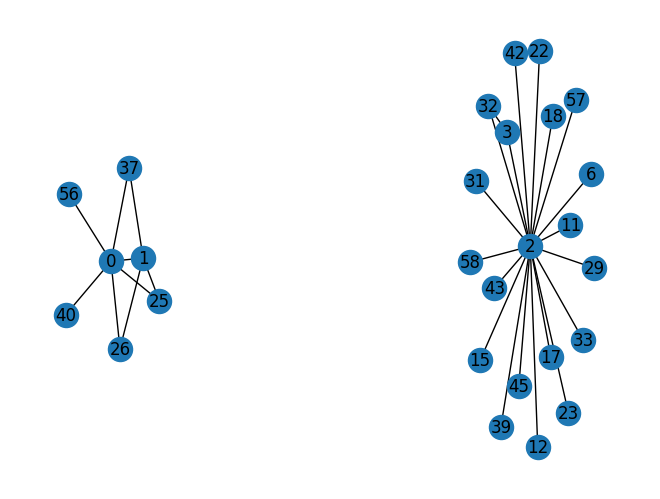

In [107]:
select_net = 698 #107 # 3980
num_features = len(graphes[select_net].x[0])
data = copy.deepcopy(graphes[select_net])
num_features

# plot the graph
G = nx.Graph()
G.add_edges_from([(r1, r2) for r1, r2 in zip(data.edge_index[:,:30].numpy()[0], data.edge_index.numpy()[1])])
nx.draw(G, cmap = plt.get_cmap('jet'), with_labels=True)
plt.show()

In [91]:
import copy
select_net = 107 # 3980
num_features = len(graphes[select_net].x[0])
data = copy.deepcopy(graphes[select_net])
print(data)
num_features

Data(x=[1034, 576], edge_index=[2, 53498])


576

In [99]:
from scipy.sparse.csgraph import shortest_path
from torch_geometric.utils import k_hop_subgraph, to_scipy_sparse_matrix
# source : https://github.com/rusty1s/pytorch_geometric/blob/master/examples/seal_link_pred.py

_max_z_ = 0

def extract_enclosing_subgraphs(df, link_index, edge_index, num_hops, y):
    """
    Extract enclosing subgraphs for every pair of nodes in the graph and label the nodes
    in each extracted subgraph.
    
    Args:
    :param link_index : edges in the graph
    :param edge_index : edges in the graph
    :param num_hops : number of hops
    :param y : if true link 
    """
    data_list = []
    for src, dst in link_index.t().tolist():
        src_origin = src
        dst_origin = dst
        sub_nodes, sub_edge_index, mapping, _ = k_hop_subgraph(
            [src, dst], num_hops, edge_index, relabel_nodes=True)
        src, dst = mapping.tolist()

        # Remove target link from the subgraph.
        mask1 = (sub_edge_index[0] != src) | (sub_edge_index[1] != dst)
        mask2 = (sub_edge_index[0] != dst) | (sub_edge_index[1] != src)
        sub_edge_index = sub_edge_index[:, mask1 & mask2]

        # Calculate node labeling.
        z = drnl_node_labeling(sub_edge_index, src, dst,
                               num_nodes=sub_nodes.size(0))
        
        data = Data(x=df.x[sub_nodes], z=z, src=src_origin, dst=dst_origin, 
                    edge_index=sub_edge_index, y=y, sub_nodes=sub_nodes)
        data_list.append(data)

    return data_list

def drnl_node_labeling(edge_index, src, dst, num_nodes=None):
    """
    Label the nodes in each subgraph (z = 1 for source and target nodes)
    assigning a label to each node according to the following formula :
    fl(i) = 1 + min(dx, dy) + (d/2)[(d/2) + (d%2) − 1], (10)
    where dx := d(i, x), dy := d(i, y), d := dx + dy, (d/2) and (d%2) are the integer quotient and
    remainder of d divided by 2, respectively
    Thus the label depends on the distance between the node and the source and target nodes
    
    Args:
    :param edge_index : edges in the graph
    :param src : source node
    :param src : target node
    :param num_nodes : number of nodes in the subgraph
    
    """
    global _max_z_
    # Double-radius node labeling (DRNL).
    src, dst = (dst, src) if src > dst else (src, dst)
    adj = to_scipy_sparse_matrix(edge_index, num_nodes=num_nodes).tocsr()  # to sparse adjacency matrix

    idx = list(range(src)) + list(range(src + 1, adj.shape[0]))
    adj_wo_src = adj[idx, :][:, idx]

    idx = list(range(dst)) + list(range(dst + 1, adj.shape[0]))
    adj_wo_dst = adj[idx, :][:, idx]

    dist2src = shortest_path(adj_wo_dst, directed=False, unweighted=True) # shortest path for between nodes
    dist2src = dist2src[:, src]
    dist2src = np.insert(dist2src, dst, 0, axis=0)
    dist2src = torch.from_numpy(dist2src)

    dist2dst = shortest_path(adj_wo_src, directed=False, unweighted=True)
    dist2dst = dist2dst[:, dst - 1]
    dist2dst = np.insert(dist2dst, src, 0, axis=0)
    dist2dst = torch.from_numpy(dist2dst)

    dist = dist2src + dist2dst
    dist_over_2, dist_mod_2 = dist // 2, dist % 2

    z = 1 + torch.min(dist2src, dist2dst)
    z += dist_over_2 * (dist_over_2 + dist_mod_2 - 1)
    z[src] = 1.
    z[dst] = 1.
    z[torch.isnan(z)] = 0.

    _max_z_ = max(int(z.max()), _max_z_)

    return z.to(torch.long)
    
# Example labelling
src_orig, dst_orig = 7, 12
num_hops = 2

sub_nodes, sub_edge_index, mapping, _ = k_hop_subgraph(
    [src_orig, dst_orig], num_hops, data.edge_index, relabel_nodes=True)
src, dst = mapping.tolist()
num_nodes = sub_nodes.size(0)

# Remove target link from the subgraph.
mask1 = (sub_edge_index[0] != src) | (sub_edge_index[1] != dst)
mask2 = (sub_edge_index[0] != dst) | (sub_edge_index[1] != src)
sub_edge_index = sub_edge_index[:, mask1 & mask2]

z_scores = drnl_node_labeling(sub_edge_index, src, dst, num_nodes)

sub_nodes[:10], z_scores[:10]

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([4, 6, 6, 9, 6, 6, 4, 1, 6, 6]))

In [114]:
from torch_geometric.data import InMemoryDataset
import math
from torch_geometric.utils import to_undirected, add_self_loops
import random
from itertools import chain
from torch_geometric.loader import DataLoader

class SEALDataset(InMemoryDataset):
    def __init__(self, df):
        super(SEALDataset, self).__init__()
        self.data, self.slices = df[0], df[1]
        
        
def train_test_split_edges_seal(data, val_ratio=0.05, test_ratio=0.1, undirected=True):
    r"""Splits the edges of a :obj:`torch_geometric.data.Data` object
    into positive and negative train/val/test edges, and adds attributes of
    `train_pos_edge_index`, `train_neg_adj_mask`, `val_pos_edge_index`,
    `val_neg_edge_index`, `test_pos_edge_index`, and `test_neg_edge_index`
    to :attr:`data`.
    Args:
        data (Data): The data object.
        val_ratio (float, optional): The ratio of positive validation
            edges. (default: :obj:`0.05`)
        test_ratio (float, optional): The ratio of positive test
            edges. (default: :obj:`0.1`)
    :rtype: :class:`torch_geometric.data.Data`
    """

    assert 'batch' not in data  # No batch-mode.

    random.seed(77)
    torch.manual_seed(77)

    num_nodes = data.num_nodes
    row, col = data.edge_index
    data.edge_index = None

    # Return upper triangular portion.
    mask = row < col
    row, col = row[mask], col[mask]

    n_v = int(math.floor(val_ratio * row.size(0)))
    n_t = int(math.floor(test_ratio * row.size(0)))

    # Positive edges.
    perm = torch.randperm(row.size(0))
    row, col = row[perm], col[perm]

    r, c = row[:n_v], col[:n_v]
    data.val_pos_edge_index = torch.stack([r, c], dim=0)
    r, c = row[n_v:n_v + n_t], col[n_v:n_v + n_t]
    data.test_pos_edge_index = torch.stack([r, c], dim=0)

    r, c = row[n_v + n_t:], col[n_v + n_t:]
    data.train_pos_edge_index = torch.stack([r, c], dim=0)
    if undirected:
        data.train_pos_edge_index = to_undirected(data.train_pos_edge_index)

    # Negative edges.
    neg_adj_mask = torch.ones(num_nodes, num_nodes, dtype=torch.uint8)
    neg_adj_mask = neg_adj_mask.triu(diagonal=1).to(torch.bool)
    neg_adj_mask[row, col] = 0

    neg_row, neg_col = neg_adj_mask.nonzero(as_tuple=False).t()
    perm = torch.randperm(neg_row.size(0))[:n_v + n_t]
    neg_row, neg_col = neg_row[perm], neg_col[perm]

    neg_adj_mask[neg_row, neg_col] = 0
    data.train_neg_adj_mask = neg_adj_mask

    row, col = neg_row[:n_v], neg_col[:n_v]
    data.val_neg_edge_index = torch.stack([row, col], dim=0)

    row, col = neg_row[n_v:n_v + n_t], neg_col[n_v:n_v + n_t]
    data.test_neg_edge_index = torch.stack([row, col], dim=0)

    return data

random.seed(12345)
torch.manual_seed(12345)
num_hops = 2

data_splitted = train_test_split_edges_seal(copy.copy(data) ,val_ratio=0.1, undirected=False)

edge_index_loop, _ = add_self_loops(data_splitted.train_pos_edge_index)
data_splitted.train_neg_edge_index = negative_sampling(
    edge_index_loop, num_nodes=data_splitted.num_nodes,
    num_neg_samples=data_splitted.train_pos_edge_index.size(1))


# Collect a list of subgraphs for training, validation and test.
train_pos_list = extract_enclosing_subgraphs(data,
    data_splitted.train_pos_edge_index, data_splitted.train_pos_edge_index, num_hops, 1)
train_neg_list = extract_enclosing_subgraphs(data,
    data_splitted.train_neg_edge_index, data_splitted.train_pos_edge_index, num_hops, 0)

val_pos_list = extract_enclosing_subgraphs(data,
    data_splitted.val_pos_edge_index, data_splitted.train_pos_edge_index, num_hops, 1)
val_neg_list = extract_enclosing_subgraphs(data,
    data_splitted.val_neg_edge_index, data_splitted.train_pos_edge_index, num_hops, 0)

test_pos_list = extract_enclosing_subgraphs(data,
    data_splitted.test_pos_edge_index, data_splitted.train_pos_edge_index, num_hops, 1)
test_neg_list = extract_enclosing_subgraphs(data,
    data_splitted.test_neg_edge_index, data_splitted.train_pos_edge_index, num_hops, 0)

for dt in chain(train_pos_list, train_neg_list, val_pos_list,
                          val_neg_list, test_pos_list, test_neg_list):
            
    z = F.one_hot(dt.z, _max_z_ + 1).to(torch.float)
    dt.x = torch.cat([z, dt.x], 1)
    
# concatenate all the subgraphs 
train_dataset = InMemoryDataset.collate(train_pos_list + train_neg_list)
test_dataset = InMemoryDataset.collate(test_pos_list + test_neg_list)
val_dataset = InMemoryDataset.collate(val_pos_list + val_neg_list)

# dataloaders for train, test, val 
batch_size = 32
train_loader = DataLoader(SEALDataset(train_dataset), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(SEALDataset(val_dataset), batch_size=batch_size)
test_loader = DataLoader(SEALDataset(test_dataset), batch_size=batch_size)

In [116]:
import torch
from torch.nn import ModuleList, Linear, Conv1d, MaxPool1d

import math
import torch_geometric
from torch_geometric.nn import GCNConv, global_sort_pool
from torch_geometric.utils import to_undirected

class DGCNN(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers, GNN=torch_geometric.nn.GCNConv, k=0.6):
        super(DGCNN, self).__init__()

        if k < 1:  # Transform percentile to number.
            num_nodes = sorted([data.num_nodes for data in train_loader])
            k = num_nodes[int(math.ceil(k * len(num_nodes))) - 1]
            k = max(10, k)
        self.k = int(k)

        self.convs = ModuleList()
        self.convs.append(GNN(train_dataset[0].num_features, hidden_channels, normalize=False, bias=False))
        for i in range(0, num_layers - 1):
            self.convs.append(GNN(hidden_channels, hidden_channels, normalize=False, bias=False))
        self.convs.append(GNN(hidden_channels, 1, normalize=False, bias=False))

        conv1d_channels = [4, 8]
        total_latent_dim = hidden_channels * num_layers + 1
        conv1d_kws = [total_latent_dim, 5]
        self.conv1 = Conv1d(1, conv1d_channels[0], conv1d_kws[0],
                            conv1d_kws[0], bias=False)
        self.maxpool1d = MaxPool1d(2, 2)
        self.conv2 = Conv1d(conv1d_channels[0], conv1d_channels[1],
                            conv1d_kws[1], 1, bias=False)
        dense_dim = int((self.k - 2) / 2 + 1)
        dense_dim = (dense_dim - conv1d_kws[1] + 1) * conv1d_channels[1]
        self.lin1 = Linear(dense_dim, 10)
        self.lin2 = Linear(10, 1)

    def forward(self, x, edge_index, batch):
        xs = [x]
        for conv in self.convs:
            xs += [torch.tanh(conv(xs[-1], edge_index))]
          
        x = torch.cat(xs[1:], dim=-1) 

        # Global pooling.
        x = global_sort_pool(x, batch, self.k)
        x = x.unsqueeze(1)  # [num_graphs, 1, k * hidden]
        x = F.relu(self.conv1(x))
        x = self.maxpool1d(x)
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # [num_graphs, dense_dim]

        # MLP.
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

In [117]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [118]:
hidden_channel = 5
num_layers = 1

model = DGCNN(hidden_channels=hidden_channel, num_layers=num_layers).to(device)    

In [143]:
# 1)
"""
As we removed from "train_test_split_edges_seal" function the transformation to undirected subgraph to save space, 
we need to reintroduce this transformation at this stage (line 90).  
In this way we do message passing in both directions. 
During the aggregation we also want to include the own features of the nodes,
thus we add a self loop (line 91).
data.edge_index 
tensor([[0, 0, 1, 1, 2],
        [1, 4, 2, 4, 3]])
        
data.edge_index after applying to_undirected
tensor([[0, 0, 1, 1, 1, 2, 2, 3, 4, 4],
        [1, 4, 0, 2, 4, 1, 3, 2, 0, 1]])
data.edge_index to_undirected + self loops
tensor([[0, 0, 1, 1, 1, 2, 2, 3, 4, 4, 0, 1, 2, 3, 4],
        [1, 4, 0, 2, 4, 1, 3, 2, 0, 1, 0, 1, 2, 3, 4]])
"""

model.train()
for data in train_loader:
    print(data)
    data = data.to(device)
    data.edge_index = to_undirected(data.edge_index)
    data.edge_index = add_self_loops(data.edge_index)[0]
    break


DataBatch(x=[400, 61], edge_index=[2, 1255], y=[32], z=[400], src=[32], dst=[32], sub_nodes=[400], batch=[400], ptr=[33])


In [161]:
# 2) Transform original features with a weight matrix
for name, param in model.named_parameters():
    print(name)
# model.convs[0].lin.weight

# weights from the convolutional layers
W0 = model.convs[0].lin.weight
W0 = torch.t(W0)
W1 = model.convs[1].lin.weight
W1 = torch.t(W1)

W0.shape, W1.shape

convs.0.lin.weight
convs.1.lin.weight
conv1.weight
conv2.weight
lin1.weight
lin1.bias
lin2.weight
lin2.bias


(torch.Size([61, 5]), torch.Size([5, 1]))

In [169]:
# 3) Compute the new nodes' features by aggregating the neighbours' 
#    features of each node (here the aggregation function is a simple sum)
"""
data.edge_index : tensor([[0, 0, 1, 1, 1, 2, 2, 3, 4, 4, 0, 1, 2, 3, 4],
                          [1, 4, 0, 2, 4, 1, 3, 2, 0, 1, 0, 1, 2, 3, 4]])
"""
transformed_feats_layer_1 = torch.matmul(data.x, W0) 
# new node 0 features : by aggregating features from nodes 1, 4 and itself according 
# to data.edge_index. Similarly for the other nodes (here aggregating function is a 
# simple sum).
x0 = torch.tanh(transformed_feats_layer_1[1, : ] + transformed_feats_layer_1[4, : ] +
                transformed_feats_layer_1[0, : ]) 
x1 = torch.tanh(transformed_feats_layer_1[0, :] + transformed_feats_layer_1[2, :]  +
                transformed_feats_layer_1[4, :] + transformed_feats_layer_1[1, :]) 
x2 = torch.tanh(transformed_feats_layer_1[1, : ] + transformed_feats_layer_1[3, : ] +
                transformed_feats_layer_1[2, : ])
x3 = torch.tanh(transformed_feats_layer_1[2, : ] + transformed_feats_layer_1[3, : ])
x4 =  torch.tanh(transformed_feats_layer_1[0, : ] + transformed_feats_layer_1[1, : ] +
                 transformed_feats_layer_1[4, : ])

# we can also write it this way:
def torch_conv(W, X_feats, hidden_dim,  edge_index, num_nodes):
    """
    Args: 
    :param W : Weights in the convolutional layer
    :param X_feats : features in the subgraph
    :param hidden_dim : hidden dimension
    :param edge_index : edges between nodes 
    :param edge_index : number of nodes in the subgraph
    """
    features = torch.matmul(X_feats, W).index_select(-2, edge_index[0])
    expanded_feats = edge_index[1].unsqueeze(-1).expand_as(features)
    out = torch.zeros(num_nodes, hidden_dim, device=device).scatter_add_(0, expanded_feats, features)
    return torch.tanh(out)

first_layer_conv = torch_conv(W0, data.x, hidden_channel, data.edge_index, data.num_nodes)
second_layer_conv = torch_conv(W1, first_layer_conv, 1, data.edge_index, data.num_nodes) # last hidden channel is 1

"""
first_layer_conv = tensor([[ 0.9999, -0.3791,  0.9987,  0.1685, -0.9730],
                            [ 1.0000, -0.8808,  0.9992, -0.3502, -0.9982],
                            [ 1.0000, -0.9186,  0.9995, -0.1444, -0.9994],
                            [ 0.9989, -0.9863,  0.9378, -0.5083, -0.9962],
                            [ 0.9999, -0.3791,  0.9987,  0.1685, -0.9730]]
                        
second_layer_conv = tensor([[-0.9989],
                            [-0.9999],
                            [-0.9979],
                            [-0.9805],
                            [-0.9989]]
"""
first_layer_conv.shape, second_layer_conv.shape

(torch.Size([400, 5]), torch.Size([400, 1]))

In [170]:
# 4) Concatenate the convolutional layers
concatenated = torch.cat([first_layer_conv, second_layer_conv], dim=1)

"""
concatenated = tensor([[ 0.9999, -0.3791,  0.9987,  0.1685, -0.9730, -0.9989],
                        [ 1.0000, -0.8808,  0.9992, -0.3502, -0.9982, -0.9999],
                        [ 1.0000, -0.9186,  0.9995, -0.1444, -0.9994, -0.9979],
                        [ 0.9989, -0.9863,  0.9378, -0.5083, -0.9962, -0.9805],
                        [ 0.9999, -0.3791,  0.9987,  0.1685, -0.9730, -0.9989]]
"""
concatenated.shape

torch.Size([400, 6])

In [167]:
# 5) Apply global sort pooling
def globalsort_pooling(X, k):
    """
    Args: 
    :param X : concatenated features
    :param k :   
    """
    # X[:, -1] : last layer of convolution approximates Weisfeiler-Lehman nodes colouring, thus 
    # we can use it to consistently sort the nodes according to their structural role.
    reshaped_sorted_feats = X.index_select(-2, X[:,-1].sort(descending=True)[1])
    padding = torch.zeros(k - X.size(0), X.size(1), device=device)
    return torch.cat([reshaped_sorted_feats, padding], 0).reshape(1,-1)

global_pool = globalsort_pooling(concatenated, model.k)

"""
reshaped_sorted_feats = tensor([[ 0.9989, -0.9863,  0.9378, -0.5083, -0.9962, -0.9805],
                                [ 1.0000, -0.9186,  0.9995, -0.1444, -0.9994, -0.9979],
                                [ 0.9999, -0.3791,  0.9987,  0.1685, -0.9730, -0.9989],
                                [ 0.9999, -0.3791,  0.9987,  0.1685, -0.9730, -0.9989],
                                [ 1.0000, -0.8808,  0.9992, -0.3502, -0.9982, -0.9999]])
                                
# k = 10 in this case, so we need to pad for 5 additional nodes                            
padding = tensor([[0., 0., 0., 0., 0., 0.],
                [0., 0., 0., 0., 0., 0.],
                [0., 0., 0., 0., 0., 0.],
                [0., 0., 0., 0., 0., 0.],
                [0., 0., 0., 0., 0., 0.]])
                
global_pool = tensor([[ 0.9989, -0.9863,  0.9378, -0.5083, -0.9962, -0.9805,  1.0000, -0.9186,
                      0.9995, -0.1444, -0.9994, -0.9979,  0.9999, -0.3791,  0.9987,  0.1685,
                     -0.9730, -0.9989,  0.9999, -0.3791,  0.9987,  0.1685, -0.9730, -0.9989,
                      1.0000, -0.8808,  0.9992, -0.3502, -0.9982, -0.9999,  0.0000,  0.0000,
                      0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
                      0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
                      0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
                      0.0000,  0.0000,  0.0000,  0.0000]])
"""
global_pool

tensor([[-1.0000, -0.9982,  0.5775,  ..., -0.8733,  0.9527, -1.0000]],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [168]:
global_pool.shape

torch.Size([1, 2400])

### SAGE

https://medium.com/stanford-cs224w/online-link-prediction-with-graph-neural-networks-46c1054f2aa4
https://colab.research.google.com/drive/1mzvskulGoM9uXCkc4Cke3_Ch0-lz_HnN

https://medium.com/stanford-cs224w/predicting-drug-drug-interactions-using-graph-neural-networks-6a093cc59a33


In [180]:
# Graph Neural Network with a few layers of GraphSAGE convolution for message passing
class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, emb=False):
        super(GNNStack, self).__init__()
        conv_model = torch_geometric.nn.SAGEConv

        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        self.dropout = dropout
        self.num_layers = num_layers
        self.emb = emb

        assert (self.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(self.num_layers - 1):
            self.convs.append(conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(self.dropout),
            nn.Linear(hidden_dim, output_dim))

    def forward(self, x, edge_index):
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.post_mp(x)

        # Return node embeddings after post-message passing if specified
        if self.emb:
            return x

        # Else return class probabilities for each node
        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [181]:
class LinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(LinkPredictor, self).__init__()

        self.lins = nn.ModuleList()
        self.lins.append(nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x)

In [264]:
# def train(model, link_predictor, emb, edge_index, pos_train_edge, batch_size, optimizer):
def train(model, link_predictor, emb, edge_index, graph, batch_size, optimizer):
    """
    Runs offline training for model, link_predictor and node embeddings given the message
    edges and supervision edges.
    1. Updates node embeddings given the edge index (i.e. the message passing edges)
    2. Computes predictions on the positive supervision edges
    3. Computes predictions on the negative supervision edges (which are sampled)
    4. Computes the loss on the positive and negative edges and updates parameters
    """
    model.train()
    link_predictor.train()

    train_losses = []

#     for edge_id in DataLoader(range(pos_train_edge.shape[0]), batch_size, shuffle=True):
    for edge_id in DataLoader(range(graph.train_pos_edge_index.shape[0]), batch_size, shuffle=True):
        
        
        optimizer.zero_grad()
        
#         print(edge_id)
#         print(edge_index)
        
        node_emb = model(emb, edge_index)  # (N, d)

#         pos_edge = pos_train_edge[edge_id].T  # (2, B)
        pos_edge = graph.train_pos_edge_index[edge_id].T  # (2, B)
        
        pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])  # (B, )

        neg_edge = graph.train_neg_edge_index[edge_id].T  # (2, B)
#         neg_edge = negative_sampling(edge_index, num_nodes=emb.shape[0],
#                                      num_neg_samples=edge_id.shape[0], method='dense')  # (Ne,2)
        neg_pred = link_predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]])  # (Ne,)

        loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    return sum(train_losses) / len(train_losses)


# loss = train(model, link_predictor, emb.weight, edge_index, graph, batch_size, optimizer)


In [241]:
graph.test_pos_edge_index
graph.test_pos_edge_index.shape[0]
# Data(x=[1034, 576], val_pos_edge_index=[2, 1337], test_pos_edge_index=[2, 2674], train_pos_edge_index=[2, 45476], train_neg_adj_mask=[1034, 1034], val_neg_edge_index=[2, 1337], test_neg_edge_index=[2, 2674])
graph

Data(x=[1034, 576], val_pos_edge_index=[2, 1337], test_pos_edge_index=[2, 2674], train_pos_edge_index=[2, 45476], train_neg_adj_mask=[1034, 1034], val_neg_edge_index=[2, 1337], test_neg_edge_index=[2, 2674])

In [324]:
# def test(model, predictor, emb, edge_index, split_edge, batch_size, evaluator):
def test(model, predictor, emb, edge_index, graph, batch_size, evaluator=None):
    
    """
    Evaluates model on positive and negative test edges
    1. Computes the updated node embeddings given the edge index (i.e. the message passing edges)
    2. Computes predictions on the positive and negative edges
    3. Calculates hits @ k given predictions using the ogb evaluator
    """
    model.eval()
    predictor.eval()

    node_emb = model(emb, edge_index)

#     pos_test_edge = split_edge['test']['edge'].to(emb.device)
#     neg_test_edge = split_edge['test']['edge_neg'].to(emb.device)
#     pos_valid_edge = split_edge['valid']['edge'].to(emb.device)
#     neg_valid_edge = split_edge['valid']['edge_neg'].to(emb.device)
#     pos_test_edge = split_edge['test']['edge'].to(emb.device)
#     neg_test_edge = split_edge['test']['edge_neg'].to(emb.device)
    pos_valid_edge = graph.val_pos_edge_index
    neg_valid_edge = graph.val_neg_edge_index
    pos_test_edge = graph.test_pos_edge_index
    neg_test_edge = graph.test_neg_edge_index
    
    pos_valid_preds = []
    for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
        edge = pos_valid_edge[perm].t()
        pos_valid_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
    pos_valid_pred = torch.cat(pos_valid_preds, dim=0)

    neg_valid_preds = []
    for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
        edge = neg_valid_edge[perm].t()
        neg_valid_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
    neg_valid_pred = torch.cat(neg_valid_preds, dim=0)
    
    pos_test_preds = []
    for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
        edge = pos_test_edge[perm].t()
        pos_test_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
    pos_test_pred = torch.cat(pos_test_preds, dim=0)

    neg_test_preds = []
    for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
        edge = neg_test_edge[perm].t()
        neg_test_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
    neg_test_pred = torch.cat(neg_test_preds, dim=0)

    results = {}
    for K in [ 2, 3, 5, 10]:
#         print(f"pos_test_pred: {pos_test_pred}")
#         print(f"neg_test_pred: {neg_test_pred}")
        valid_hits = hits_k_eval(y_pred_pos=pos_valid_preds, y_pred_neg=neg_valid_preds, k=K)
        test_hits = hits_k_eval(y_pred_pos=pos_test_pred, y_pred_neg=neg_test_pred, k=K)
#         evaluator.K = K #using the Evaluator function in the ogb.linkproppred package
#         test_hits = evaluator.eval({
#             'y_pred_pos': pos_test_pred,
#             'y_pred_neg': neg_test_pred,
#         })[f'hits@{K}']
#         results[f'Hits@{K}'] = test_hits
        results[f'Hits@{K}'] = (valid_hits, test_hits)

    return results

In [299]:
# graph.train_pos_edge_index[:, :32]

In [300]:
# Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optim_wd = 0
epochs = 300
hidden_dim = 256
dropout = 0.3
num_layers = 2
lr = 3e-3
node_emb_dim = 256
batch_size = 64 * 1024

In [251]:
import copy
select_net = 107 # 3980
num_features = len(graphes[select_net].x[0])
data = copy.deepcopy(graphes[select_net])

edge_index = data.edge_index
print(data)
num_features

Data(x=[1034, 576], edge_index=[2, 53498])


576

In [254]:

edge_index

tensor([[   0,    0,    0,  ..., 1031, 1032, 1033],
        [ 476,  258,  101,  ...,   49,  751,  597]])

In [253]:
from torch_geometric.utils import train_test_split_edges
data = train_test_split_edges(data)
print(data)

Data(x=[1034, 576], val_pos_edge_index=[2, 1337], test_pos_edge_index=[2, 2674], train_pos_edge_index=[2, 45476], train_neg_adj_mask=[1034, 1034], val_neg_edge_index=[2, 1337], test_neg_edge_index=[2, 2674])


In [249]:
graph.edge_index
edge_index

tensor([[   0,    0,    0,  ..., 1031, 1032, 1033],
        [ 476,  258,  101,  ...,   49,  751,  597]])

In [217]:
# split_edges = dataset.get_edge_split()
# train_edges, valid_edges, test_edges = split_edges['train'], \ 
#                                        split_edges['valid'], \
#                                        split_edges['test']

In [302]:
# import ogb
# from ogb.linkproppred import Evaluator
# evaluator = Evaluator()
# # evaluator = Evaluator(name = "ogbl-ddi")
# # evaluator.K = 3
# # evaluator.eval({'y_pred_pos': torch.tensor([0.95, 0.7, 0.6, 0.4]), 
# #                 'y_pred_neg': torch.tensor([0.6, 0.5, 0.45, 0.2])})
# # >>> 0.75

In [312]:
def hits_k_eval(y_pred_pos, y_pred_neg, k, type_info='torch'):
    '''
        compute Hits@K
        For each positive target node, the negative target nodes are the same.

        y_pred_neg is an array.
        rank y_pred_pos[i] against y_pred_neg for each i
    '''

    if len(y_pred_neg) < k:
#         return {'hits@{}'.format(k): 1.}
        return 1.

    if type_info == 'torch':
        kth_score_in_negative_edges = torch.topk(y_pred_neg, k)[0][-1]
        hitsK = float(torch.sum(y_pred_pos > kth_score_in_negative_edges).cpu()) / len(y_pred_pos)

    # type_info is numpy
    else:
        kth_score_in_negative_edges = np.sort(y_pred_neg)[-k]
        hitsK = float(np.sum(y_pred_pos > kth_score_in_negative_edges)) / len(y_pred_pos)

#     return {'hits@{}'.format(k): hitsK}
    return hitsK
# print(f"pos_test_pred: {graph.pos_test_pred}")
# print(f"neg_test_pred: {graph.neg_test_pred}")
# pos_test_pred: tensor([0.1280, 0.1344], grad_fn=<CatBackward0>)
# neg_test_pred: tensor([0.1829, 0.1387],
# temp_pos = torch.tensor([0.1280, 0.1344])
# temp_neg = torch.tensor([0.1829, 0.1387])
# print(f"temp_pos: {temp_pos}")
# print(f"temp_neg: {temp_neg}")
K = 3
hit = hits_k_eval(y_pred_pos=temp_pos, y_pred_neg=temp_neg, k=K)
print(f"hits@{K} = {hit}")

hits@3 = 1.0


In [285]:
def hits_count(dup_ranks, k):
    """
        dup_ranks: list индексов дубликатов
        result: вернуть  Hits@k
    """
    hits_value = 0
    for rank in dup_ranks:
        hits_value += 1 if rank <= k else 0
    hits_value = hits_value/len(dup_ranks)
    return hits_value
rankings = np.array([1, 12, 6, 2])
# rankings = np.array([2, 1])
hits_count(rankings, k=2)

# >>> hits_at_n_score(rankings, n=3)

0.5

In [328]:
# split_edge = dataset.get_edge_split()
# pos_train_edge = split_edge['train']['edge'].to(device)

graph = data
graph = graph.to(device)
edge_index = edge_index.to(device)
# edge_index = graph.edge_index #.to(device)

# evaluator = Evaluator(name='ogbl-ddi')

emb = torch.nn.Embedding(graph.num_nodes, node_emb_dim).to(device) # each node has an embedding that has to be learnt
model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, emb=True).to(device) # the graph neural network that takes all the node embeddings as inputs to message pass and agregate
link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device) # the MLP that takes embeddings of a pair of nodes and predicts the existence of an edge between them
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(link_predictor.parameters()) + list(emb.parameters()),
    lr=lr, weight_decay=optim_wd
)

train_loss = []
val_hits = []
test_hits = []
for e in range(epochs):
#     loss = train(model, link_predictor, emb.weight, edge_index, pos_train_edge, batch_size, optimizer)
    loss = train(model, link_predictor, emb.weight, edge_index, graph, batch_size, optimizer)
    print(f"Epoch {e + 1}: loss: {round(loss, 5)}")
    train_loss.append(loss)

    if (e+1)%10 ==0:
#         https://github.com/snap-stanford/ogb/blob/master/ogb/linkproppred/evaluate.py
#         result = test(model, link_predictor, emb.weight, edge_index, split_edge, batch_size, evaluator)
        result = test(model, link_predictor, emb.weight, edge_index, graph, batch_size)
        val_hits.append(result['Hits@2'][0])
        test_hits.append(result['Hits@2'][1])
        print(result)


Epoch 1: loss: 1.39098
Epoch 2: loss: 1.39379
Epoch 3: loss: 1.37597
Epoch 4: loss: 1.3866
Epoch 5: loss: 1.32459
Epoch 6: loss: 1.22122
Epoch 7: loss: 0.8797
Epoch 8: loss: 0.18615
Epoch 9: loss: 0.0002
Epoch 10: loss: 0.0
{'Hits@2': (1.0, 1.0), 'Hits@3': (1.0, 1.0), 'Hits@5': (1.0, 1.0), 'Hits@10': (1.0, 1.0)}
Epoch 11: loss: 3e-05
Epoch 12: loss: 0.0
Epoch 13: loss: 0.0
Epoch 14: loss: 0.01276
Epoch 15: loss: 0.0
Epoch 16: loss: 0.0
Epoch 17: loss: 34.53878
Epoch 18: loss: 34.53878
Epoch 19: loss: 34.53878
Epoch 20: loss: 34.53878
{'Hits@2': (1.0, 0.0), 'Hits@3': (1.0, 1.0), 'Hits@5': (1.0, 1.0), 'Hits@10': (1.0, 1.0)}
Epoch 21: loss: 34.53878
Epoch 22: loss: 34.53878
Epoch 23: loss: 34.53878
Epoch 24: loss: 34.53878
Epoch 25: loss: 34.53878
Epoch 26: loss: 34.53878
Epoch 27: loss: 34.53878
Epoch 28: loss: 34.53878
Epoch 29: loss: 34.53878
Epoch 30: loss: 34.53878
{'Hits@2': (1.0, 0.0), 'Hits@3': (1.0, 1.0), 'Hits@5': (1.0, 1.0), 'Hits@10': (1.0, 1.0)}
Epoch 31: loss: 34.53878
Epoch

Epoch 244: loss: 34.53878
Epoch 245: loss: 34.53878
Epoch 246: loss: 34.53878
Epoch 247: loss: 34.53878
Epoch 248: loss: 34.53878
Epoch 249: loss: 34.53878
Epoch 250: loss: 34.53878
{'Hits@2': (1.0, 0.0), 'Hits@3': (1.0, 1.0), 'Hits@5': (1.0, 1.0), 'Hits@10': (1.0, 1.0)}
Epoch 251: loss: 34.53878
Epoch 252: loss: 34.53878
Epoch 253: loss: 34.53878
Epoch 254: loss: 34.53878
Epoch 255: loss: 34.53878
Epoch 256: loss: 34.53878
Epoch 257: loss: 34.53878
Epoch 258: loss: 34.53878
Epoch 259: loss: 34.53878
Epoch 260: loss: 34.53878
{'Hits@2': (1.0, 0.0), 'Hits@3': (1.0, 1.0), 'Hits@5': (1.0, 1.0), 'Hits@10': (1.0, 1.0)}
Epoch 261: loss: 34.53878
Epoch 262: loss: 34.53878
Epoch 263: loss: 34.53878
Epoch 264: loss: 34.53878
Epoch 265: loss: 34.53878
Epoch 266: loss: 34.53878
Epoch 267: loss: 34.53878
Epoch 268: loss: 34.53878
Epoch 269: loss: 34.53878
Epoch 270: loss: 34.53878
{'Hits@2': (1.0, 0.0), 'Hits@3': (1.0, 1.0), 'Hits@5': (1.0, 1.0), 'Hits@10': (1.0, 1.0)}
Epoch 271: loss: 34.53878
Ep

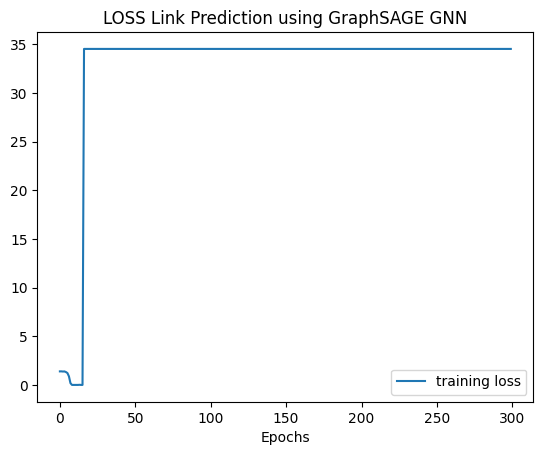

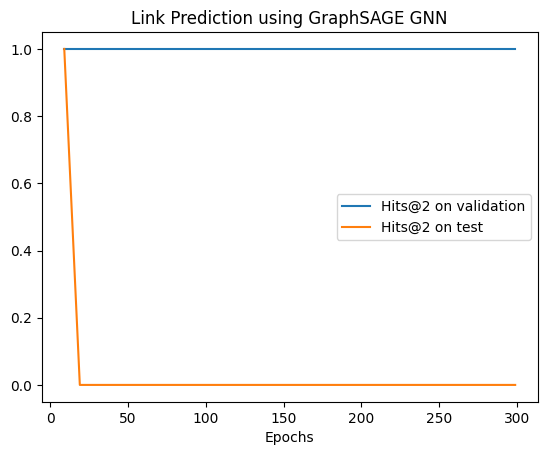

In [330]:
plt.title('LOSS Link Prediction using GraphSAGE GNN')
plt.plot(train_loss,label="training loss")
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.title('Link Prediction using GraphSAGE GNN')
plt.plot(np.arange(9,epochs,10),val_hits,label="Hits@2 on validation")
plt.plot(np.arange(9,epochs,10),test_hits,label="Hits@2 on test")
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [215]:
data

Data(x=[1034, 576], edge_index=[2, 53498])

In [213]:
data_split.num_nodes

1034

### Эмбеддинги и Кластеризация 

In [9]:
select_net = 107
num_features = len(graphes[select_net].x[0])
num_features

576

In [10]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(576, 16)
  (conv2): GCNConv(16, 2)
)


In [11]:
data = graphes[select_net]
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)

In [12]:
out[:2], torch.argmax(out[:50], dim=1)

(tensor([[ 0.0260, -0.0568],
         [ 0.0285, -0.0423]], grad_fn=<SliceBackward0>),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
         0, 0]))

In [61]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


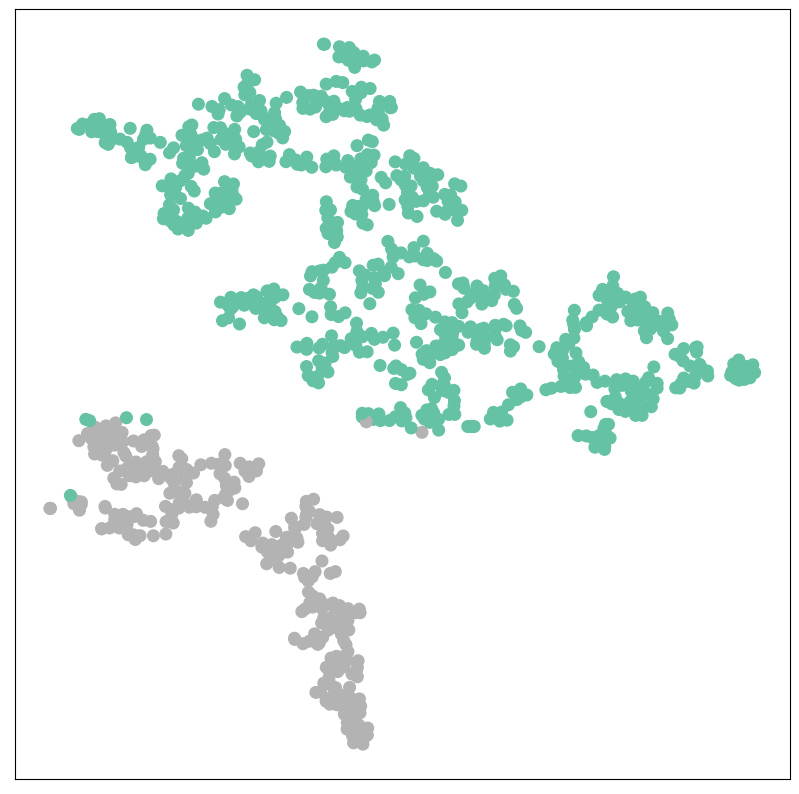

In [14]:
visualize(out, color=torch.argmax(out, dim=1))

In [57]:
select_net = 107
num_features = len(graphes[select_net].x[0])

In [58]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.gcn_layers = Sequential('x, edge_index',[
            (GCNConv(num_features, hidden_channels), 'x, edge_index -> x'),
            ReLU(),
            Dropout(p=0.5),
            BatchNorm(hidden_channels),
            (GCNConv(hidden_channels, hidden_channels*2), 'x, edge_index -> x'),
            ReLU(),
            Dropout(p=0.5),
            (GCNConv(hidden_channels*2, 2), 'x, edge_index -> x'),
#             Linear(hidden_channels*2, 2),
        ]
        )
        
        self.conv1 = GCNConv(num_features, hidden_channels)

    def forward(self, x, edge_index):
        x = self.gcn_layers(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (gcn_layers): Sequential(
    (0): GCNConv(576, 16)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): BatchNorm(16)
    (4): GCNConv(16, 32)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): GCNConv(32, 2)
  )
  (conv1): GCNConv(576, 16)
)


In [59]:
data = graphes[select_net]
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)

D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


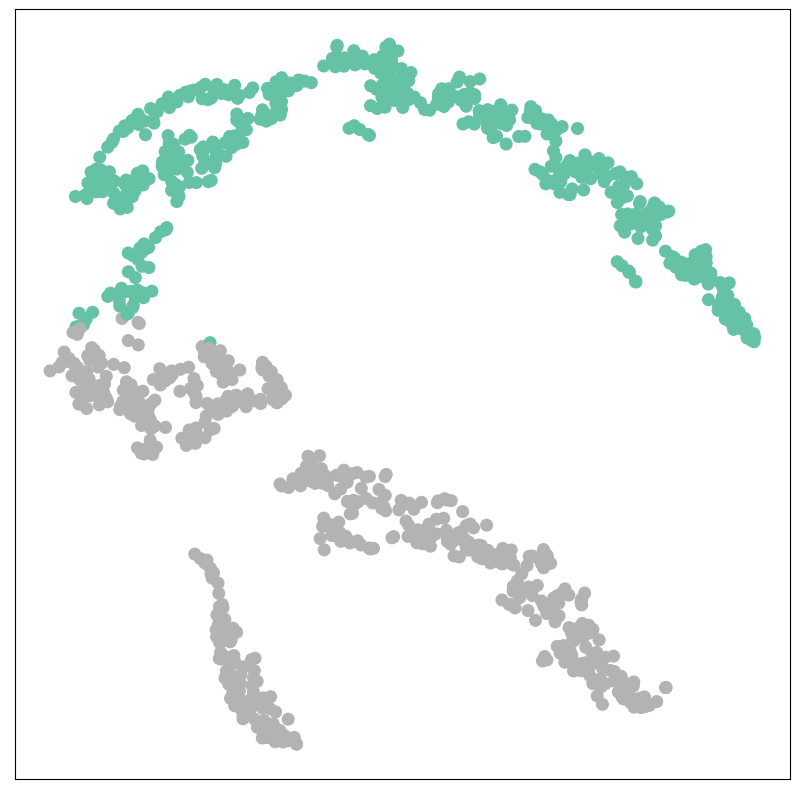

In [62]:
visualize(out, color=torch.argmax(out, dim=1))

#### DBSCAN кластеризация

In [63]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=0.005, min_samples=5)

In [64]:
dbs.fit(out.detach().cpu())

DBSCAN(eps=0.005)

In [65]:
labels = dbs.labels_
labels.min(), labels.max()
labels

array([ 0,  0,  0, ...,  1, -1,  1], dtype=int64)

In [66]:
z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
df_dbscan = pd.DataFrame(z)
df_dbscan["label"] = labels
# df_dbscan

D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


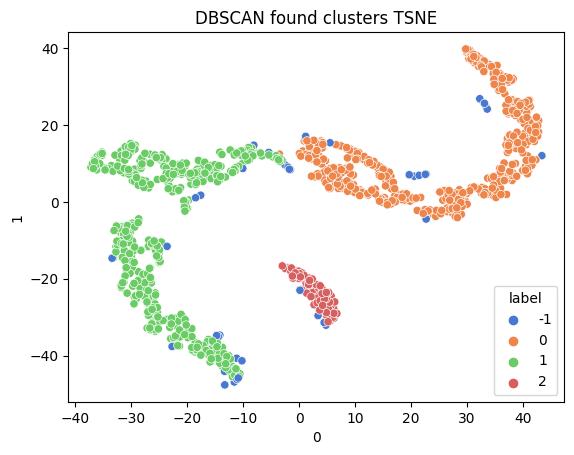

In [70]:
import seaborn as sns
sns.scatterplot(data=df_dbscan, x=0, y=1, 
                hue='label', palette='muted').set_title('DBSCAN found clusters TSNE');

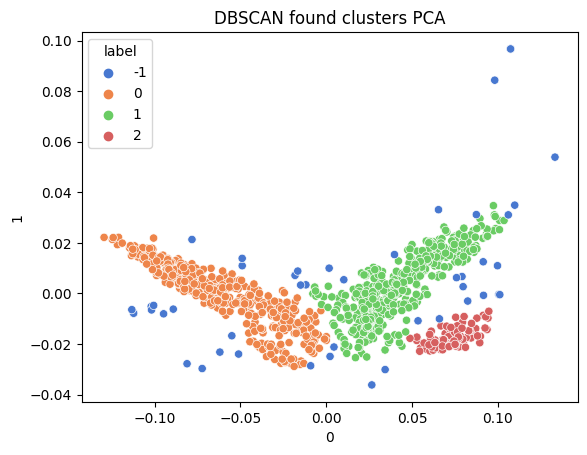

In [69]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
z = pca.fit_transform(out.detach().cpu().numpy())

df_dbscan_pca = pd.DataFrame(z)
df_dbscan_pca["label"] = labels

sns.scatterplot(data=df_dbscan_pca, x=0, y=1, 
                hue='label', palette='muted').set_title('DBSCAN found clusters PCA');


### Поиск похожих вершин

### KNN

In [53]:
select_net = 0
num_features = len(graphes[select_net].x[0])

In [78]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.gcn_layers = Sequential('x, edge_index',[
            (GCNConv(num_features, hidden_channels), 'x, edge_index -> x'),
            ReLU(),
            Dropout(p=0.5),
            BatchNorm(hidden_channels),
            (GCNConv(hidden_channels, hidden_channels*2), 'x, edge_index -> x'),
#             ReLU(),
#             Dropout(p=0.5),
#             (GCNConv(hidden_channels*2, 30), 'x, edge_index -> x'),
        ]
        )
        
        self.conv1 = GCNConv(num_features, hidden_channels)

    def forward(self, x, edge_index):
        x = self.gcn_layers(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (gcn_layers): Sequential(
    (0): GCNConv(224, 16)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): BatchNorm(16)
    (4): GCNConv(16, 32)
  )
  (conv1): GCNConv(224, 16)
)


In [79]:
data = graphes[select_net]
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)

In [80]:
select_node = 187
nodes_nets[select_net][select_node]

196

In [81]:
out = out.detach().cpu()
out.shape

torch.Size([333, 32])

In [82]:
list(nodes_nets[select_net]).index(196)

187

In [83]:
out[select_node], out[select_node][None]

(tensor([ 0.0108,  0.0780, -0.0366, -0.0494, -0.0070, -0.0166,  0.0408, -0.1074,
          0.0703,  0.0155, -0.0200, -0.0476,  0.0214, -0.0100,  0.0205,  0.0670,
          0.0947, -0.0478, -0.0707, -0.0150, -0.0206,  0.1139,  0.0286,  0.0044,
          0.0439,  0.0488, -0.0357, -0.0210,  0.0439, -0.0732,  0.0538,  0.0186]),
 tensor([[ 0.0108,  0.0780, -0.0366, -0.0494, -0.0070, -0.0166,  0.0408, -0.1074,
           0.0703,  0.0155, -0.0200, -0.0476,  0.0214, -0.0100,  0.0205,  0.0670,
           0.0947, -0.0478, -0.0707, -0.0150, -0.0206,  0.1139,  0.0286,  0.0044,
           0.0439,  0.0488, -0.0357, -0.0210,  0.0439, -0.0732,  0.0538,  0.0186]]))

In [84]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=5)
knn.fit(out)
knn

NearestNeighbors()

In [87]:
neighbors = knn.kneighbors(out[select_node][None], n_neighbors =10 , return_distance = False)
print(neighbors)

[[187 173   4  36 134  47 100 166  37 221]]


In [88]:
print(f"node by index: {nodes_nets[select_net][select_node]}")
print(f"find neighbors: {[nodes_nets[select_net][i] for i in neighbors[0]]}")

node by index: 196
find neighbors: [196, 330, 24, 254, 187, 299, 302, 266, 194, 101]


In [77]:
print(f"node by index: {nodes_nets[select_net][select_node]}")
print(f"find neighbors: {[nodes_nets[select_net][i] for i in neighbors[0]]}")

node by index: 196
find neighbors: [196, 330, 57, 24, 187]


https://medium.com/mlearning-ai/embedding-similarity-search-25c6911240af

In [ ]:
from annoy import AnnoyIndex
import random
t = AnnoyIndex(d, 'angular')  # Length of item vector that will be indexed
for i in range(len(S)):
    t.add_item(i, S[i])
    
t.build(10) # 10 trees
print(u.get_nns_by_vector(x, k)) # will find the k nearest neighbours

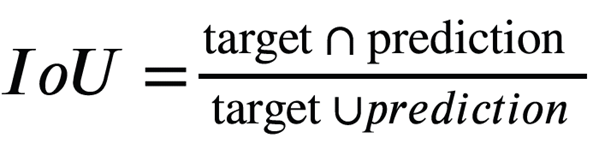

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 